# MNIST using GAN in TensorFlow
Let us build a simple GAN capable of generating handwritten digits. We will use the MNIST handwritten digits to train the network.

(from "Deep Learning with Tensorflow 2 and Keras" by Antonio Gulli, Amita Kapoor, Sujit Pal)

### required modules

In [28]:
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from datetime import datetime

### load the dataset
ignore Y_train, X_test, Y_test

In [29]:
(X_train, _), (_, _) = keras.datasets.mnist.load_data()

Normalize the input values such that each pixel has a value in range \[-1,1\]:

In [30]:
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
print("shape of X_train: ", X_train.shape)

shape of X_train:  (60000, 28, 28)


We will use a simple **multi-layered perceptron (MLP)** and we will feed it in image as a flat vector of size 784 (28x28), so we reshape the training data:

In [31]:
X_train = X_train.reshape(60000, 784)
print("shape of X_train: ", X_train.shape)

shape of X_train:  (60000, 784)


### The Generator
Now we need to build a generator and discriminator. The purpose of generator is to take a noisy input and generate an image similar to the training dataset. The size of the noisy input is decided by the variable <code>randomDim</code>; you can initialize it to any integral value. Conventionally people set it to 100. For our implementation we tried a value of 10.

> The number of neurons in the output unit has to match the number of pixels in the training images. 

In [32]:
# Optimizer
adam = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

randomDim = 10

generator = keras.Sequential(name='generator')
generator.add(Dense(256, input_dim=randomDim))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               2816      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 784)               80

### The Discriminator
Similarly, we build a discriminator. Notice now that the discriminator takes in the images, either from the training set or images generated by generator, thus its input size is <code>784</code>. The ouput of discriminator however is a single bit, with 0 signifying a fake image (generated by generator) ad 1 signifying that the image is from the training dataset

In [33]:
discriminator = keras.Sequential(name='discriminator')
discriminator.add(Dense(
    1024, 
    input_dim=784, 
    kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)
    ))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(
    loss='binary_crossentropy',
    optimizer=adam
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)             

Next, we combine the generator and discriminator together to form a GAN. In the GAN we ensure that the discriminator weights are fixed by the <code>trainable</code> argumento to <code>false</code>

In [34]:
discriminator.trainable = False
ganInput = Input(shape=(randomDim,), name='gan_input')
x = generator(ganInput)
ganOutput = discriminator(x)
gan = keras.Model(name='gan', inputs=ganInput, outputs=ganOutput)

gan.compile(
    loss='binary_crossentropy',
    optimizer=adam
)

gan.summary()

Model: "gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gan_input (InputLayer)       [(None, 10)]              0         
_________________________________________________________________
generator (Sequential)       (None, 784)               1463312   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 1460225   
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


the trick to train the two is that we first train the discriminator separately; we use binary cross entropy loss for discriminator. Later we freeze the weights of the disciminator and the train the combined GAN; this results in the training of generator. The loss this time is also binary cross entropy:

let us perform the training. For each epoch we take a sample of random noise first, feed it to generator, and the generator produces a fake image. We combine the generated fake images and the actual training images in a batch with their specific labels and use them to train the discriminator first on the given batch.

Then, in the same for loop, we will train the generator. We want the images generated by the generator to be deteced as real by discriminator, so we use a random vector (noise) as input to the generator; this generates a fake image a then trains the GAN such that discriminator perceives the image as real:

In [35]:
dLosses = []
gLosses = []

def train(epochs=1, batchSize=128):
    batchCount = int(X_train.shape[0] / batchSize)
    print('Training samples: ', X_train.shape[0])
    print('Epochs: ', epochs)
    print('Batch size: ', batchSize)
    print('Batches per epoch: ', batchCount)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)

        for _ in range(batchCount):
            # Get a random set of input noise ad images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0],size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)

            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train the discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train the generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)
        
        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 20 == 0:
            saveGeneratedImages(e)        
            plotLoss(e)

In [36]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminative loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_loss_epoch_%d.png' % epoch)


In [37]:
# Create a wall of generated MNIST images
def saveGeneratedImages(epoch, examples=100, dim=(10,10), figsize=(10,10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('images/gen_generated_image_epoch_%d.png' % epoch)

train the model

Training samples:  60000
Epochs:  1
Batch size:  128
Batches per epoch:  468
--------------- Epoch 1 ---------------


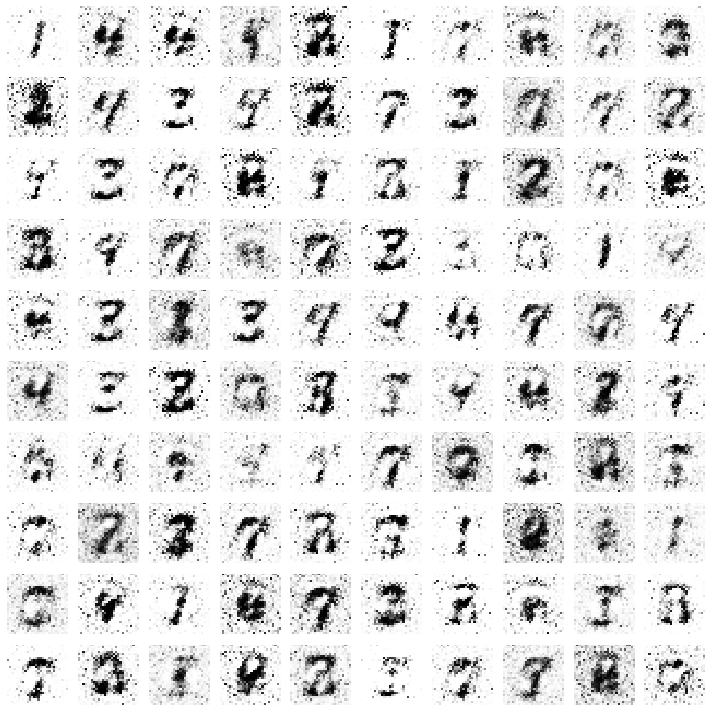

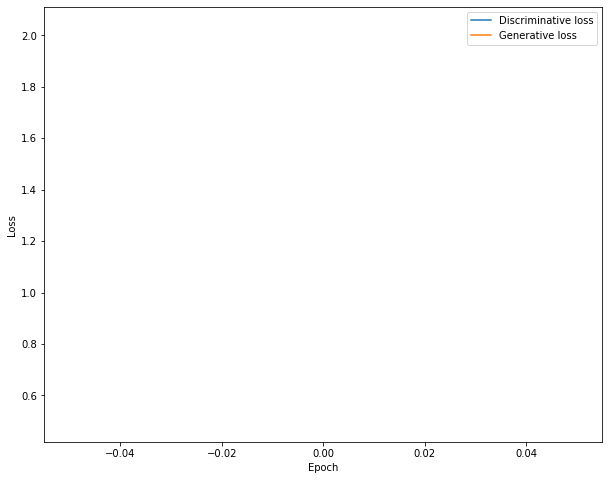

In [27]:
train(200, 128)